In [162]:
%reload_ext autoreload
%autoreload 2
import importlib
import tornet.data.preprocess as preprocess
importlib.reload(preprocess)

# s TornadoModel project
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import optim, nn
from torch.utils.data import Dataset
from torchvision import transforms, utils

# Now import tornet modules
from tornet.data.constants import ALL_VARIABLES
from tornet.data.loader import read_file, TornadoDataLoader
from tornet.data.preprocess import add_coordinates, remove_time_dim, permute_dims

In [163]:
%reload_ext autoreload
%autoreload 2

import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# Path to your local dataset root
data_root = '/Users/jackgao/Downloads/data'

data_type = 'train'  # or 'test'
years = [2013, 2014]

# Load and filter the catalog
catalog_path = os.path.join(data_root, 'catalog.csv')
if not os.path.exists(catalog_path):
    raise RuntimeError('Unable to find catalog.csv at ' + data_root)

catalog = pd.read_csv(catalog_path, parse_dates=['start_time', 'end_time'])
catalog = catalog[catalog['type'] == data_type]
catalog = catalog[catalog.start_time.dt.year.isin(years)]
catalog = catalog.sample(frac=1, random_state=1234)  # Shuffle rows

# Construct full file paths
file_list = [os.path.join(data_root, f) for f in catalog.filename]

# Define your dataset
class TornadoDataset(TornadoDataLoader, Dataset):
    pass

# If you already removed the time dimension
transform = transforms.Compose([
    lambda d: add_coordinates(d, include_az=False, tilt_last=False, backend=torch),
    lambda d: remove_time_dim(d),
])

# Instantiate dataset
torch_ds = TornadoDataset(
    file_list,
    variables=ALL_VARIABLES,
    n_frames=1,
    tilt_last=False,
    transform=transform
)

# DataLoader
batch_size = 32
torch_dl = torch.utils.data.DataLoader(
    torch_ds,
    batch_size=batch_size,
    num_workers=0
)

In [ ]:
%reload_ext autoreload
%autoreload 2

"""
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Department of the Air Force under Air Force Contract No. FA8702-15-D-0001. Any opinions, findings, conclusions or recommendations expressed in this material are those of the author(s) and do not necessarily reflect the views of the Department of the Air Force.

© 2024 Massachusetts Institute of Technology.


The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part 252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed above. Use of this work other than as specifically authorized by the U.S. Government may violate any copyrights that exist in this work.
"""

from typing import Dict, List, Tuple, Any
import numpy as np

import torch
from torch import nn, optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torchmetrics import MetricCollection
import lightning as L

from tornet.models.torch.coordconv import CoordConv2D
from tornet.data.constants import CHANNEL_MIN_MAX, ALL_VARIABLES


class TornadoClassifier(L.LightningModule):
    """
    Fits tornado classifier
    """
    def __init__(self,model:nn.Module,
                      lr:float=1e-3,
                      lr_decay_rate=0.9,
                      lr_decay_steps=1,
                      label_smoothing:float=0.2,
                      weight_decay:float=0.001,
                      metrics:MetricCollection=None):
        super().__init__()
        self.model=model
        self.lr=lr
        self.label_smoothing=label_smoothing
        self.weight_decay=weight_decay
        self.lr_decay_rate=lr_decay_rate
        self.lr_decay_steps=lr_decay_steps
        self.loss = nn.CrossEntropyLoss(label_smoothing=0.2)

        if metrics:
            self.train_metrics = metrics.clone(prefix='train_')
            self.valid_metrics = metrics.clone(prefix='val_')
            self.test_metrics = metrics.clone(prefix='test_')
        else:
            self.train_metrics=self.valid_metrics=self.test_metrics=None

    def forward(self,batch):
        return self.model(batch)
        
    def training_step(self, batch, _):
        y = torch.squeeze(batch.pop('label')) # [batch]
        logits = self.model(batch) # [batch,1,L,W] 
        logits = F.max_pool2d(logits, kernel_size=logits.size()[2:]) # [batch,1,1,1] 
        logits = torch.cat( (-logits,logits),axis=1)  # [batch,2,1,1] 
        logits = torch.squeeze(logits) # [batch,2] for binary classification
        loss = self.loss(logits, y)
        
        # Logging..
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        if self.train_metrics:
            met_out = self.train_metrics(logits[:,1],y)
            self.log_dict(met_out, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self,batch,_):
        y,logits,loss=self._shared_eval(batch)
        
        # Logging..
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        if self.valid_metrics:
            self._log_metrics(self.valid_metrics,y,logits)
        return loss
    
    def test_step(self,batch,_):
        y,logits,loss=self._shared_eval(batch)
        
        # Logging..
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        if self.test_metrics:
            self._log_metrics(self.test_metrics,y,logits)
        return loss

    def _shared_eval(self,batch):
        y = torch.squeeze(batch.pop('label')) # [batch]
        logits = self.model(batch) # [batch,1,L,W] 
        logits = F.max_pool2d(logits, kernel_size=logits.size()[2:]) # [batch,1,1,1] 
        logits = torch.cat( (-logits,logits),axis=1)  # [batch,2,1,1] 
        logits = torch.squeeze(logits) # [batch,2] for binary classification
        loss = self.loss(logits, y)
        return y,logits,loss
    
    def _log_metrics(self,metrics,y,logits):
        met_out = metrics(logits[:,1],y)
        self.log_dict(met_out, on_step=False, on_epoch=True, prog_bar=True, logger=True)


    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), 
                               lr=self.lr,
                               weight_decay=self.weight_decay)
        
        # Define the learning rate scheduler
        scheduler = {
            'scheduler': StepLR(optimizer, 
                                step_size=self.lr_decay_steps, 
                                gamma=self.lr_decay_rate),
            'interval': 'epoch',  # Adjust the learning rate at the end of each epoch
            'frequency': 1  # Apply the scheduler every epoch
        }
        return [optimizer], [scheduler]


class TornadoLikelihood(nn.Module):
    """
    Produces 2D tornado likelihood field
    """
    def __init__(self,  shape:Tuple[int]=(2,120,240),
                        c_shape:Tuple[int]=(2,120,240),
                        input_variables:List[str]=ALL_VARIABLES,
                        start_filters:int=64,
                        background_flag:float=-3.0,
                        include_range_folded:bool=True):
        super(TornadoLikelihood, self).__init__()
        self.input_shape=shape
        self.n_sweeps=shape[0]
        self.c_shape=c_shape
        self.input_variables=input_variables
        self.start_filters=start_filters
        self.background_flag=background_flag
        self.include_range_folded=include_range_folded
        
        # Set up normalizers
        self.input_norm_layers = {}
        for v in input_variables:
            min_max = np.array(CHANNEL_MIN_MAX[v]) # [2,]
            scale = 1/(min_max[1]-min_max[0])
            offset = min_max[0]
            self.input_norm_layers[v] = NormalizeVariable(scale,offset)
            
        # Processing blocks
        in_channels = (len(input_variables)+int(self.include_range_folded))*self.n_sweeps
        in_coords=self.c_shape[0]
        self.blk1 = VggBlock(in_channels,in_coords,start_filters,   kernel_size=3,  n_convs=2, drop_rate=0.1)   # (60,120)
        self.blk2 = VggBlock(start_filters,in_coords,2*start_filters, kernel_size=3,  n_convs=2, drop_rate=0.1)  # (30,60)
        self.blk3 = VggBlock(2*start_filters,in_coords,4*start_filters, kernel_size=3,  n_convs=3, drop_rate=0.1)  # (15,30)
        self.blk4 = VggBlock(4*start_filters,in_coords,8*start_filters, kernel_size=3,  n_convs=3, drop_rate=0.1)  # (7,15)
        
        self.head = nn.Sequential(
            nn.Conv2d(in_channels=8*start_filters, out_channels=512, kernel_size=(1,1)),
             nn.ReLU(),
             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=(1,1)),
             nn.ReLU()
        )
        self.conv_out = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=(1,1))
        
        
    def _normalize_inputs(self,data):
        normed_data = {}
        for v in self.input_variables:
            normed_data[v] = self.input_norm_layers[v](data[v])
        return normed_data
    
    def forward(self,data: Dict[str,Any]):
        """
        Assumes data contains radar varialbes on [batch,tilt,az,rng]
        and coordinate tensor
        """
        # extract inputs
        x = {v:data[v] for v in self.input_variables} # each [batch,tilt,Az,Rng]
        c = data['coordinates']
        
        # normalize
        x = self._normalize_inputs(x) # each [batch,tilt,Az,Rng]
        
        # concatenate along channel (tilt) dim
        x = torch.cat([x[v] for v in self.input_variables],axis=1) #  [batch,tilt*len(input_variables)*2,Az,Rng]
        
        # Remove nan's
        x = torch.where(torch.isnan(x),self.background_flag,x)
        
        # concat range_Folded mask
        if self.include_range_folded:
            x = torch.cat((x,data['range_folded_mask']),axis=1)
        
        # process
        x,c=self.blk1((x,c))
        x,c=self.blk2((x,c))
        x,c=self.blk3((x,c))
        x,c=self.blk4((x,c))
        x = self.head(x)

        # output single channel heatmap for likelihood field
        x = self.conv_out(x)

        return x




class NormalizeVariable(nn.Module):
    """
    Normalize input tensor as (X-offset)*scale
    """
    def __init__(self, scale, offset):
        super(NormalizeVariable, self).__init__()
        self.register_buffer('scale', torch.tensor(scale))
        self.register_buffer('offset', torch.tensor(offset))

    def forward(self, x):
        return (x - self.offset) * self.scale


class VggBlock(nn.Module):
    """
    Processing block based on VGG19, with coord conv layers
    """
    def __init__(self, input_image_channels,
                       input_coordinate_channels,
                       n_output_channels,
                       kernel_size=3,
                       n_convs=3,
                       drop_rate=0.1):
        super(VggBlock, self).__init__()
        self.input_image_channels=input_image_channels
        self.input_coordinate_channels=input_coordinate_channels
        self.n_output_channels=n_output_channels
        self.kernel_size=kernel_size
        self.n_convs=n_convs
        self.drop_rate=drop_rate

        self.steps = []
        for k in range(n_convs):
            if k==0:
                in_channels=input_image_channels
            else:
                in_channels=n_output_channels
            self.steps.append(CoordConv2D(in_image_channels=in_channels,
                                          in_coord_channels=input_coordinate_channels,
                                          out_channels=n_output_channels, 
                                          kernel_size=kernel_size,
                                          padding='same',
                                          activation='relu'))
        self.conv_block = nn.Sequential(*self.steps)
        self.mx=nn.MaxPool2d(2, stride=2)
        self.mc=nn.MaxPool2d(2, stride=2)
        if drop_rate>0:
            self.drop=nn.Dropout(p=drop_rate)
        else:
            self.drop=None

    def forward(self, inputs):
        x,c=inputs
        x,c=self.conv_block((x,c))
        x=self.mx(x)
        c=self.mc(c)
        if self.drop:
            x=self.drop(x)
        return x,c
        

In [168]:
%reload_ext autoreload
%autoreload 2

# Train this model using torch lightning
import lightning as L
import torchmetrics
from torchmetrics import MetricCollection
from tornet.models.torch.cnn_baseline import TornadoClassifier
# Metrics expected to be binary classification metrics that expect (logits,label)
#    where logits and label are both (N,) tensors 
#    e.g. torchmetrics.classification.BinaryAccuracy
metrics = MetricCollection([
            torchmetrics.classification.BinaryAccuracy(), 
            torchmetrics.classification.BinaryAUROC(), 
            torchmetrics.classification.BinaryAveragePrecision()
        ])

cnn = TornadoLikelihood()
classifier = TornadoClassifier(cnn,metrics=metrics)

# Low number of train_batches/epochs only for demo purposes
trainer = L.Trainer(limit_train_batches=10, max_epochs=10)
trainer.fit(classifier,train_dataloaders=torch_dl)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/jackgao/Downloads/TornadoModel/tornetPredict/.venv/lib/python3.13/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | model         | TornadoLikelihood | 8.1 M  | train
1 | loss          | CrossEntropyLoss  | 0      | train
2 | train_metrics | MetricCollection  | 0      | train
3 | valid_metrics | MetricCollection  | 0      | train
4 | test_metrics  | MetricCollection  | 0      | train
------------------------------------------------------------
8.

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


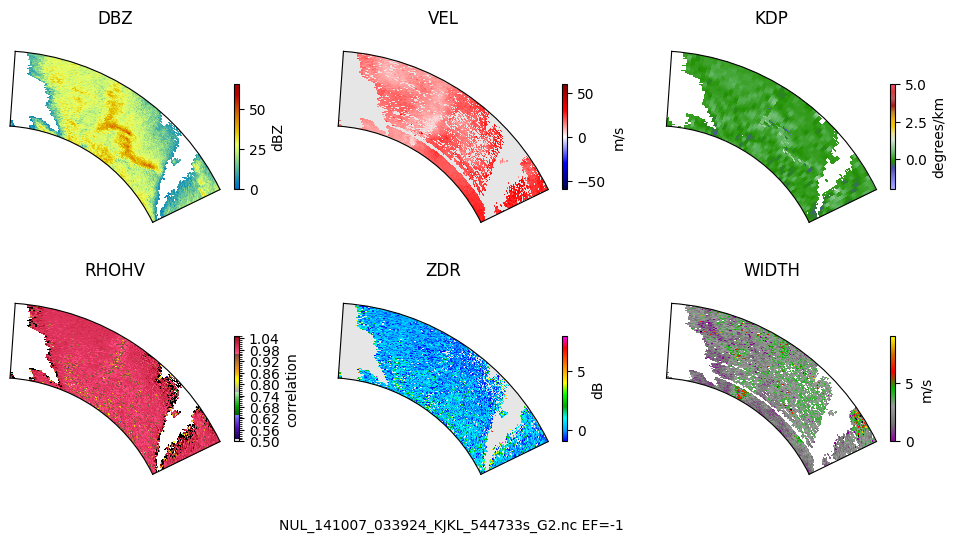

In [169]:
from tornet.data.loader import TornadoDataLoader
from tornet.display.display import plot_radar

# list which variables to plot
vars_to_plot=['DBZ', 'VEL', 'KDP', 'RHOHV', 'ZDR', 'WIDTH']

# Grab a single sample using data loader
dindx =3 # 22
n_frames=4
data_loader = TornadoDataLoader(file_list,variables=vars_to_plot,n_frames=n_frames)
data = data_loader[dindx]

fig = plt.figure(figsize=(12,6))

plot_radar(data,
           fig=fig,
           channels=vars_to_plot,
           include_cbar=True,
           time_idx=-1, # show last frame
           n_rows=2, n_cols=3)

# Add a caption (optional)
fig.text(.5, .05, os.path.basename(data_loader.file_list[dindx])+' EF='+str(data['ef_number'][0]) , ha='center');